<a href="https://colab.research.google.com/github/adamggibbs/marine-carbonate-system-ml-prediction/blob/master/NN_pH_Prediction_Development_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pH ML Model Training Pipeline

# Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Necessary User Defined Variables

In [1]:
# name of folder in Google Drive 
# should be a relative path from 'My Drive' and end with trailing '/'
root_dir_name = 'Adam Gibbs/'

# desired name of trained model
final_model_name = 'Our Model'

# save options for intermediate data files
# can save both or either .txt and .csv files
save_txt = False
save_csv = True

# save figures?
save_figs = False
# display figures?
show_figs = True

# Environment Set Up
Imports, hyperparameters, figure settings

In [3]:
# IMPORTS

import os
import math
import copy
from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
sns.set_color_codes(palette='colorblind')

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# data dirs
root_dir = '/content/drive/MyDrive/'+ root_dir_name + '/'
data_dir = root_dir + 'data/'
training_dir=data_dir + 'training/'
model_dir = data_dir + 'models/'
fig_dir = data_dir + 'figs/'
testing_dir = data_dir + 'testing/'

# model hyperparams
layer1 = 48
layer2 = 24

# model evaluation and fig settings
shallow = 200
d_label = "\n(Depths <{})".format(shallow)

m_col = 'b'
c_col = 'g'


# Data QC, Cleaning, and Preprocessing Functions

In [4]:
# FUNCTION TO READ GLIDER FILE IN A PANDAS DATAFRAME
def read_glider_file(file):
  names = [ 'Cruise', 'Station', 'Type',	'DATE', 'TIME', 'LONGITUDE',	
         'LATITUDE',	'QF',	'PRS', 'PRS_QF', 'TMP', 'TMP_QF', 
         'SAL', 'SAL_QF', 'Sigma_theta', 'ST_QF', 'DEPTH', 'DEPTH_QF', 
         'OXYGEN', 'OXYGEN_QF',	'SATOXY',	'SATOXY_QF',	'NITRATE', 
         'NITRATE_QF', 'CHL_A', 'CHL_A_QF', 'BBP700', 'BBP700_QF', 'PH_INSITU', 
         'PH_INSITU_QF', 'BBP532', 'BBP_532_QF', 'CDOM', 'CDOM_QF', 'TALK_CANYONB',	
         'TALK_QF', 'DIC_CANYONB', 'DIC_QF', 'pCO2_CANYONB', 'pCO2_QF', 
         'SAT_AR_CANYONB', 'SAT_AR_QF', 'pH25C_1atm', 'pH25C_1atm_QF' ]

  df = pd.read_csv(file, skiprows=7, header=None, sep='\t', names=names)
  df = df.dropna(axis=0, how='any').reset_index(drop=True)
  
  return df

################################################################################

def check_qfs(file, save_csv=True):
  # read in csv
  dataframe = read_glider_file(file)

  df = dataframe[[ 'PH_INSITU', 'PH_INSITU_QF', 'PRS', 'PRS_QF', 'TMP', 'TMP_QF', 
           'SAL', 'SAL_QF', 'OXYGEN', 'OXYGEN_QF']].to_numpy()

  for ind in range(0, len(df)):
    # check pH QFs
    pH = df[ind][0]
    qf = df[ind][1]
    if pH < 7.3 or pH > 8.5:
      df[ind][1] = 8
    elif ind > 1 and ind + 2 < len(df):
      test = pH - np.median((df[ind-2][0], df[ind-1][0], 
                              pH, 
                              df[ind+1][0], df[ind+2][0]))
      if abs(test) > 0.04:
        df[ind][1] = 8
        
    sal = df[ind][6]
    if sal < 33 or sal > 34.5:
      df[ind][7] = 8

    # check inputs QFs
    if float(df[ind][2]) == -999:
      df[ind][3] = 8
    if float(df[ind][4]) == -999:
      df[ind][5] = 8
    if float(df[ind][6]) == -999:
      df[ind][7] = 8
    if float(df[ind][8]) == -999:
      df[ind][9] = 8

  # update pH QFs
  dataframe['PH_INSITU_QF'] = df[:,1]
  # update inputs QFs
  dataframe['PRS_QF'] = df[:,3]
  dataframe['TMP_QF'] = df[:,5]
  dataframe['SAL_QF'] = df[:,7]
  dataframe['OXYGEN_QF'] = df[:,9]

  if save_csv:
    dataframe.to_csv(glider_dir + file[-12:-3] + 'csv', header=True, index=False)

  return dataframe

################################################################################

# CREATE FUNCTION TO CREATE A NUMPY ARRAY OF INPUTS FROM
# GLIDER DATA FILE

'''
process_glider_input()
  description:
    This function reads in a data file in csv format and
    creates a pandas dataframe from it. From there it loops through
    and removes all bad data points according to the quality control
    flags. It then takes the desired input parameters as sepcified on 
    line 84 and puts them into a numpy array.

  args:
    file: string that contains file name of dataset
'''
def process_glider_file(df, save_txt=False, save_csv=False):

  # throw away first day
  start_date = int(df['DATE'][0][3:5])
  start_time = float(df['TIME'][0][0:2]) + float(df['TIME'][0][3:5]) / 60

  drop_index = 0
  for index, row in df.iterrows():
    curr_date = int(row['DATE'][3:5])
    curr_time = float(row['TIME'][0:2]) + float(row['TIME'][3:5]) / 60
    if (curr_date > start_date and curr_time > start_time) or curr_date > start_date + 1:
      drop_index = index
      break

  # drop first day of data
  df = df.drop(index=df.index[:drop_index], axis=0).reset_index(drop=True)

  # take only data we care about
  df = df[['DATE', 'LATITUDE', 'LONGITUDE', 'PRS', 'PRS_QF', 'TMP', 'TMP_QF',
          'SAL', 'SAL_QF', 'OXYGEN', 'OXYGEN_QF', 'SATOXY', 'SATOXY_QF',
          'PH_INSITU', 'PH_INSITU_QF', 'TALK_CANYONB', 'TALK_QF', 'DIC_CANYONB',
          'DIC_QF', 'pCO2_CANYONB', 'pCO2_QF']]

  # drop bad pressure
  index = 0
  to_drop = []
  for flag in df['PRS_QF']:
    if flag > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # drop bad temperature
  index = 0
  to_drop = []
  for flag in df['TMP_QF']:
    if flag > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # drop bad salinity
  index = 0
  to_drop = []
  for flag in df['SAL_QF']:
    if flag > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # drop bad oxygen
  index = 0
  to_drop = []
  for flag in df['OXYGEN_QF']:
    if flag > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # drop bad saturated oxygen
  index = 0
  to_drop = []
  for flag in df['SATOXY_QF']:
    if flag > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # drop bad pH
  index = 0
  to_drop = []
  for flag in df['PH_INSITU_QF']:
    if flag > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # take subset of only parameters for inputs
  # this array contains only "good" data points
  inputs = df[['DATE', 'LATITUDE', 'LONGITUDE', 'PRS', 'TMP', 'SAL', 'OXYGEN']]
  outputs = df['PH_INSITU']
  # convert dataframe in numpy array
  inputs = inputs.to_numpy(dtype='str')
  outputs = outputs.to_numpy(dtype='str')

  # change date format
  for row in inputs:
    date = row[0]
    row[0] = date[6:10] + date[0:2] + date[3:5]

  # return the array
  return inputs, outputs

################################################################################

def prep_data(inputs, outputs):

  # TRANSFORM DATE AND PRESSURE INPUTS

  # method to help transform date
  def date_to_nth_day(the_date):
    date = pd.to_datetime(the_date)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    day_of_the_year = (date - new_year_day).days + 1
    return day_of_the_year

  # loop through inputs and perform transformations
  for input in inputs:
    # adjust date
    date = input[0]
    frac_year = date_to_nth_day(date) / 365.0
    input[0] = int(date[0:4]) + frac_year 
    
  return inputs, outputs

# Load In

In [5]:
# load in txt data

inputs = np.loadtxt(data_dir+'glider_tpso_input.csv', 
                        delimiter=",", 
                        dtype='str')
outputs = np.loadtxt(data_dir+'glider_ph_output.csv', 
                        delimiter=",", 
                        dtype='str')

display(inputs[:6])
display(outputs[:6])


array([['20190529', '36.747', '-122.061', '500.84', '5.947', '34.222',
        '20.52'],
       ['20190529', '36.747', '-122.061', '500.28', '5.952999999999999',
        '34.218', '20.28'],
       ['20190529', '36.747', '-122.061', '499.68', '5.97', '34.216',
        '20.03'],
       ['20190529', '36.747', '-122.061', '499.0', '5.971', '34.216',
        '19.92'],
       ['20190529', '36.747', '-122.061', '498.36', '5.973', '34.216',
        '19.81'],
       ['20190529', '36.747', '-122.061', '497.64', '5.975', '34.216',
        '19.7']], dtype='<U18')

array(['7.537999999999999', '7.5375', '7.5363', '7.5365', '7.5363',
       '7.5366'], dtype='<U18')

In [6]:
# TRANSFORM DATE AND PRESSURE INPUTS

# method to help transform date
def date_to_nth_day(the_date):
  date = pd.to_datetime(the_date)
  new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
  day_of_the_year = (date - new_year_day).days + 1
  return day_of_the_year

# loop through inputs and perform transformations
for input in inputs:
  # adjust date
  date = input[0]
  frac_year = date_to_nth_day(date) / 365
  input[0] = int(date[0:4]) + frac_year 

# if desired save arrays as .txt files
if save_txt or save_csv: 

  if save_txt:
    input_header = 'DATE LATITUDE LONGITUDE CTDPRS CTDTMP CTDSAL OXYGEN'
    np.savetxt(training_dir + 'training_tpso_input(2).txt', 
                inputs, 
                fmt='%s', header=input_header)
    output_header = 'TOT_PH'
    np.savetxt(training_dir + 'training_ph_output(2).txt', 
                outputs, 
                fmt='%s', header=output_header)
  else:
    input_header = 'DATE, LATITUDE, LONGITUDE, CTDPRS, CTDTMP, CTDSAL, OXYGEN'
    np.savetxt(training_dir + 'training_tpso_input(2).csv', 
                inputs, 
                fmt='%s', delimiter=",", header=input_header)
    output_header = 'TOT_PH'
    np.savetxt(training_dir + 'training_ph_output(2).csv', 
                outputs, 
                fmt='%s', delimiter=",", header=output_header)

# GET INPUT OUTPUT ARRAYS

display(inputs[0])
display(outputs[0])

array(['2019.4082191780822', '36.747', '-122.061', '500.84', '5.947',
       '34.222', '20.52'], dtype='<U18')

'7.537999999999999'

In [7]:
train_inputs = inputs.astype(np.float)
train_outputs = outputs.astype(np.float)

display(train_inputs[0:5])
display(train_outputs[0:5])

train_inputs, train_outputs = shuffle(train_inputs, train_outputs, 
                                      random_state=101)
display(train_inputs[0:5])
display(train_outputs[0:5])

array([[2019.40821918,   36.747     , -122.061     ,  500.84      ,
           5.947     ,   34.222     ,   20.52      ],
       [2019.40821918,   36.747     , -122.061     ,  500.28      ,
           5.953     ,   34.218     ,   20.28      ],
       [2019.40821918,   36.747     , -122.061     ,  499.68      ,
           5.97      ,   34.216     ,   20.03      ],
       [2019.40821918,   36.747     , -122.061     ,  499.        ,
           5.971     ,   34.216     ,   19.92      ],
       [2019.40821918,   36.747     , -122.061     ,  498.36      ,
           5.973     ,   34.216     ,   19.81      ]])

array([7.538 , 7.5375, 7.5363, 7.5365, 7.5363])

array([[2019.61369863,   36.797     , -121.852     ,   81.2       ,
           9.855     ,   33.88      ,  106.01      ],
       [2021.26849315,   36.679     , -122.415     ,  253.32      ,
           7.73      ,   34.101     ,   53.12      ],
       [2021.23835616,   35.726     , -123.871     ,  294.76      ,
           7.1       ,   34.101     ,   39.75      ],
       [2021.21643836,   35.629     , -124.617     ,  251.12      ,
           9.214     ,   34.008     ,   70.86      ],
       [2021.2109589 ,   35.792     , -124.626     ,   94.44      ,
          11.164     ,   33.195     ,  212.47      ]])

array([7.685 , 7.5827, 7.558 , 7.6111, 7.9165])

# Create and Train Model

In [8]:
# CREATE NORMALIZER

normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(train_inputs)


In [9]:
# METHOD TO BUILD AND COMPILE MODEL

model_name = "DNN({},{})".format(layer1, layer2)

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(layer1, activation='sigmoid'),
      layers.Dense(layer2, activation='sigmoid'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=[
                         metrics.MeanAbsoluteError(),
                         metrics.MeanSquaredError(),
                         metrics.RootMeanSquaredError()
                ])
  return model

# Create model and display summary
print('Model Name: ' + model_name)
model = build_and_compile_model(normalizer)
model.summary()

Model Name: DNN(48,24)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 7)                15        
 n)                                                              
                                                                 
 dense (Dense)               (None, 48)                384       
                                                                 
 dense_1 (Dense)             (None, 24)                1176      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,600
Trainable params: 1,585
Non-trainable params: 15
_________________________________________________________________


In [10]:
%%time
history = model.fit(
    train_inputs, train_outputs,
    validation_split=0, epochs=50,
    use_multiprocessing=True)

model.save(model_dir+model_name)

Epoch 1/50
31367/31367 [==============================] - 52s 2ms/step - loss: 0.1247 - mean_absolute_error: 0.0508 - mean_squared_error: 0.1247 - root_mean_squared_error: 0.3531
Epoch 2/50
31367/31367 [==============================] - 52s 2ms/step - loss: 2.2598e-04 - mean_absolute_error: 0.0095 - mean_squared_error: 2.2598e-04 - root_mean_squared_error: 0.0150
Epoch 3/50
31367/31367 [==============================] - 51s 2ms/step - loss: 2.0240e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 2.0240e-04 - root_mean_squared_error: 0.0142
Epoch 4/50
31367/31367 [==============================] - 52s 2ms/step - loss: 1.8404e-04 - mean_absolute_error: 0.0083 - mean_squared_error: 1.8404e-04 - root_mean_squared_error: 0.0136
Epoch 5/50
31367/31367 [==============================] - 51s 2ms/step - loss: 1.7223e-04 - mean_absolute_error: 0.0079 - mean_squared_error: 1.7223e-04 - root_mean_squared_error: 0.0131
Epoch 6/50
31367/31367 [==============================] - 51s 2ms/step - 

600826
701630


2

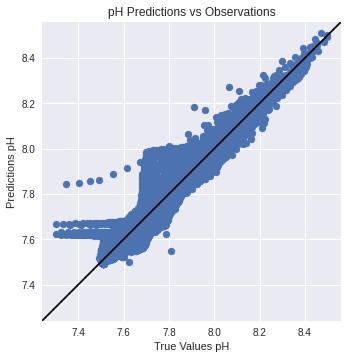

In [11]:
test_predictions = model.predict(train_inputs).flatten()

count = 0
ind = 0
for o in test_predictions:
  if float(o) < 7.3 or float(o) > 8.5:
    count += 1
    print(ind)
  ind += 1
display(count)

ax = plt.axes(aspect='equal')

plt.scatter(train_outputs, test_predictions)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.ylim(lims)
plt.xlim(lims)
plt.plot(lims,lims, color='black')

plt.title('pH Predictions vs Observations')
plt.xlabel('True Values pH')
plt.ylabel('Predictions pH')

plt.show()

# Model Evaluation

In [ ]:

test_input_arrays = []
test_output_arrays = []

for file in os.listdir(testing_dir):
  display(testing_dir+file)
  df = check_qfs(testing_dir+file, save_csv=False)

  curr_inputs, curr_outputs = process_glider_file(df)
  curr_inputs, curr_outputs = prep_data(curr_inputs, curr_outputs)
  test_input_arrays.append(curr_inputs)
  test_output_arrays.append(curr_outputs)

test_inputs = np.concatenate(test_input_arrays)
test_outputs = np.concatenate(test_output_arrays)

test_inputs = test_inputs.astype('float')
test_outputs = test_outputs.astype('float')

display(test_inputs.shape)
display(test_outputs.shape)

# Make Test Predictions

In [13]:
# make predictions on testing dataset with neural network
test_predictions = model.predict(test_inputs, verbose=1).flatten()

7303/7303 [==============================] - 8s 1ms/step


# Get Depth Data

In [ ]:
# FUNCTION: CONVERT PRESSURE TO DEPTH
# Python version of the following MATLAB function
'''
% SW_DPTH    Depth from pressure
%===========================================================================
% SW_DPTH   $Id: sw_dpth.m,v 1.1 2003/12/12 04:23:22 pen078 Exp $
%           Copyright (C) CSIRO, Phil Morgan 1992.
%
% USAGE:  dpth = sw_dpth(P,LAT)
%
% DESCRIPTION:
%    Calculates depth in metres from pressure in dbars.
%
% INPUT:  (all must have same dimensions)
%   P   = Pressure    [db]
%   LAT = Latitude in decimal degress north [-90..+90]
%         (lat may have dimensions 1x1 or 1xn where P(mxn).
%
% OUTPUT:
%  dpth = depth [metres]
%
% AUTHOR:  Phil Morgan 92-04-06  (morgan@ml.csiro.au)
%
% DISCLAIMER:
%   This software is provided "as is" without warranty of any kind.
%   See the file sw_copy.m for conditions of use and licence.
%
% REFERENCES:
%    Unesco 1983. Algorithms for computation of fundamental properties of
%    seawater, 1983. _Unesco Tech. Pap. in Mar. Sci._, No. 44, 53 pp.
%=========================================================================
'''
def pres_to_depth(pres, lat):

  # define constants
  DEG2RAD = math.pi/180
  c1 = 9.72659
  c2 = -2.2512E-5
  c3 = 2.279E-10
  c4 = -1.82E-15
  gam_dash = 2.184E-6

  # convert latitude
  LAT = abs(lat)
  X = math.sin(LAT*DEG2RAD)
  X = X*X

  # calculate denomenator and numerator
  denom = 9.780318*(1.0+(5.2788E-3 + 2.36E-5*X)*X) + gam_dash*0.5*pres 
  numer = (((c4 * pres + c3) * pres + c2) * pres + c1) * pres

  # return quotient
  return numer / denom


# FUNCTION: CONVERT ARRAY OF INPUTS TO AN ARRAY OF DEPTHS
def get_depths(input_arr):
  # create numpy array to store depths
  depths = np.zeros(len(input_arr))
  # loop through inputs and calculate depth
  ind = 0
  for input in input_arr:
    depths[ind] = pres_to_depth(input[3], input[1])
    ind += 1
  # return depth array
  return depths


# get depths from inputs
test_depths = get_depths(test_inputs)

In [15]:
# GET DATAPOINTS FROM SHALLOW DEPTHS (<200m)

# loop through depths and get indices of deep datapoints 
ind = 0
inds = []
for depth in test_depths:
  if depth > shallow:
    inds.append(ind)
  ind += 1

# delete deep datapoints and store resulting array of shallow datapoints
shallow_test_depths = np.delete(test_depths, inds, axis=0)
shallow_test_predictions = np.delete(test_predictions, inds, axis =0)
shallow_outputs = np.delete(test_outputs, inds, axis=0)

# ensure there are no deep datapoints
count = 0
for depth in shallow_test_depths:
  if depth > shallow:
    count += 1
print('Number of datapoints of depth greater than {}m: {}'.format(shallow, count))

print('Shape of each shallow data array (all should be equal):')
display(shallow_test_depths.shape)
display(shallow_test_predictions.shape)
display(shallow_outputs.shape)

Number of datapoints of depth greater than 200m: 0
Shape of each shallow data array (all should be equal):


(114139,)

(114139,)

(114139,)

# Error Metrics
### MAE, MSE, RMSE

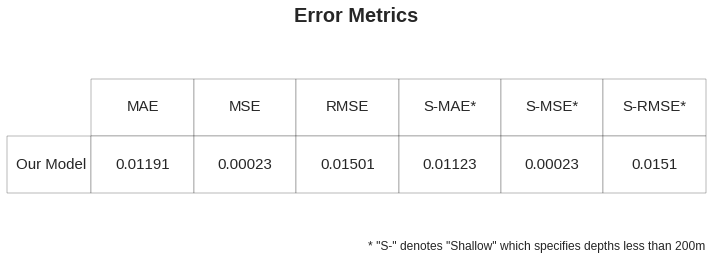

In [16]:
# TEST INITIAL PERFORMANCE ON TRAINING, VALIDATION, & TESTING SETS

model_metrics = np.zeros((1,6))

# get metrics for DNN
e_mae = mean_absolute_error(test_outputs, test_predictions)
e_mse = mean_squared_error(test_outputs, test_predictions)
e_rmse = math.sqrt(e_mse)
# round metrics to 5 decimal places
model_metrics[0][0] = np.round(e_mae, 5)
model_metrics[0][1] = np.round(e_mse, 5)
model_metrics[0][2] = np.round(e_rmse, 5)
# get metrics for DNN
e_mae = mean_absolute_error(shallow_outputs, shallow_test_predictions)
e_mse = mean_squared_error(shallow_outputs, shallow_test_predictions)
e_rmse = math.sqrt(e_mse)
# round metrics to 5 decimal places
model_metrics[0][3] = np.round(e_mae, 5)
model_metrics[0][4] = np.round(e_mse, 5)
model_metrics[0][5] = np.round(e_rmse, 5)

# create table
# labels for columns and rows
col_labels = ['MAE', 'MSE', 'RMSE', 'S-MAE*', 'S-MSE*', 'S-RMSE*']
row_labels = [final_model_name]

# add data to table
fig, ax = plt.subplots(1, figsize=(10,3.5))
table = ax.table(cellText=model_metrics, cellLoc='center', loc='center', 
                 rowLabels=row_labels, colLabels=col_labels)
# title plot
fig.suptitle('Error Metrics',
             ha='center', va='center', fontsize=20, weight='bold')
# scale plot
table.set_fontsize(15)
table.scale(1,4)
ax.axis('off')

plt.text(1,0, "* \"S-\" denotes \"Shallow\" which specifies depths less than 200m",
         ha='right', fontsize=12)

plt.tight_layout()

# save and show plot
if save_figs:
  plt.savefig(fig_dir+'combined_err_metrics.png', bbox_inches='tight')
if show_figs:
  plt.show()

## Overall Test Dataset

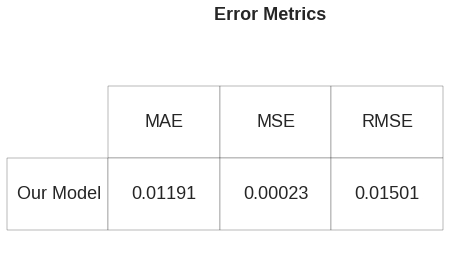

In [17]:
# create numpy array to hold metrics
model_metrics = np.zeros(shape=(1,3))

# get metrics for DNN
mae = mean_absolute_error(test_outputs, test_predictions)
mse = mean_squared_error(test_outputs, test_predictions)
rmse = math.sqrt(mse)
# round metrics to 5 decimal places
model_metrics[0][0] = np.round(mae, 5)
model_metrics[0][1] = np.round(mse, 5)
model_metrics[0][2] = np.round(rmse, 5)

# create table
# labels for columns and rows
col_labels = ['MAE', 'MSE', 'RMSE']
row_labels = [final_model_name]
# add data to table
fig, ax = plt.subplots(1, figsize=(6,4))
table = ax.table(cellText=model_metrics, cellLoc='center', loc='center', 
          rowLabels=row_labels, colLabels=col_labels)
# title plot
fig.suptitle('Error Metrics', y=1,
             ha='center', va='center', fontsize=18, weight='bold')
# scale plot
table.set_fontsize(18)
table.scale(1,6)
ax.axis('off')

# show plot
if save_figs:
  plt.savefig(fig_dir+'err_metrics_table.png', bbox_inches='tight')
if show_figs:
  plt.show()


## Shallow Test Dataset

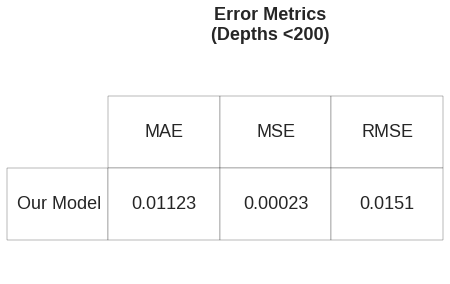

In [18]:
# create numpy array to hold metrics
model_metrics = np.zeros(shape=(1,3))

# get metrics for DNN
mae = mean_absolute_error(shallow_outputs, shallow_test_predictions)
mse = mean_squared_error(shallow_outputs, shallow_test_predictions)
rmse = math.sqrt(mse)
# round metrics to 5 decimal places
model_metrics[0][0] = np.round(mae, 5)
model_metrics[0][1] = np.round(mse, 5)
model_metrics[0][2] = np.round(rmse, 5)

# create table
# labels for columns and rows
col_labels = ['MAE', 'MSE', 'RMSE']
row_labels = [final_model_name]
# add data to table
fig, ax = plt.subplots(1, figsize=(6,4))
table = ax.table(cellText=model_metrics, cellLoc='center', loc='center', 
          rowLabels=row_labels, colLabels=col_labels)
# title plot
fig.suptitle('Error Metrics' + d_label, y=1,
             ha='center', va='center', fontsize=18, weight='bold')
# scale plot
table.set_fontsize(18)
table.scale(1,6)
ax.axis('off')

# show plot
if save_figs:
  plt.savefig(fig_dir+'err_metrics_table_shallow.png', bbox_inches='tight')
if show_figs:
  plt.show()


# Estimates vs Observations 1-1 Plots

In [19]:
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["axes.linewidth"]  = 0

## Overall Dataset

[]

Number of estimations not in range [7.3,8.5]: 0



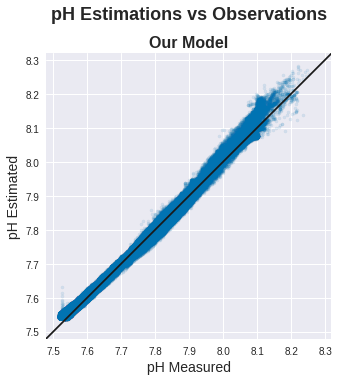

In [20]:
# count how many estimations are outside range test
count = 0
ind = 0
inds = []
for o in test_predictions:
  if float(o) < 7.3 or float(o) > 8.5:
    count += 1
    inds.append(ind)
  ind += 1
display(inds)
# print number of estimations outside range test
print('Number of estimations not in range [7.3,8.5]: {}\n'.format(count))

fig, ax1 = plt.subplots(1, 1, figsize=(10,5), sharey=True)
ax1.set_aspect('equal')

# plot scatter plots of estimations vs observations
# (x=observations, y=estimations, blue=our DNN, red=CANYON-B)
ax1.scatter(test_outputs, test_predictions, label=final_model_name,
            color=m_col, s=10, alpha=0.1)


ax1.set_xlabel('pH Measured')
ax1.xaxis.label.set_size(14)
ax1.set_ylabel('pH Estimated')
ax1.yaxis.label.set_size(14)

# get axis limits from min and max ofdata
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims,lims, color='k')
ax1.set_ylim(lims)
ax1.set_xlim(lims)

# title, label, and legend plot
fig.suptitle('pH Estimations vs Observations\n', y=1,
             va='center', fontsize=18, weight='bold')
ax1.set_title(final_model_name, fontsize=16, weight='bold')

plt.tight_layout()

# show plot
if save_figs:
  plt.tight_layout()
  plt.savefig(fig_dir+'est_v_obs.png', bbox_inches='tight')
if show_figs:
  plt.show()


## Shallow Test Dataset

In [ ]:
# count how many estimations are outside range test
count = 0
ind = 0
for o in shallow_test_predictions:
  if float(o) < 7.3 or float(o) > 8.5:
    count += 1
  ind += 1
# print number of estimations outside range test
print('Number of estimations not in range [7.3,8.5]: {}\n'.format(count))

fig, ax1 = plt.subplots(1, 1, figsize=(10,5), sharey=True)
ax1.set_aspect('equal')

# plot scatter plots of estimations vs observations
# (x=observations, y=estimations, blue=our DNN, red=CANYON-B)
ax1.scatter(shallow_outputs, shallow_test_predictions, label=final_model_name,
            color=m_col, s=10, alpha=0.1)

ax1.set_xlabel('pH Measured')
ax1.xaxis.label.set_size(14)
ax1.set_ylabel('pH Estimated')
ax1.yaxis.label.set_size(14)

# get axis limits from min and max ofdata
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims,lims, color='black')
ax1.set_ylim(lims)
ax1.set_xlim(lims)

# title, label, and legend plot
fig.suptitle('pH Estimations vs Observations' + d_label, y=1.025,
             va='center', fontsize=18, weight='bold')
ax1.set_title(final_model_name, fontsize=16, weight='bold')

plt.tight_layout()

# show plot
if save_figs:
  plt.savefig(fig_dir+'est_v_obs_shallow.png', bbox_inches='tight')
if show_figs:
  plt.show()


# Depth vs Error Plots

## DNN Error Only

### Overall Test Dataset

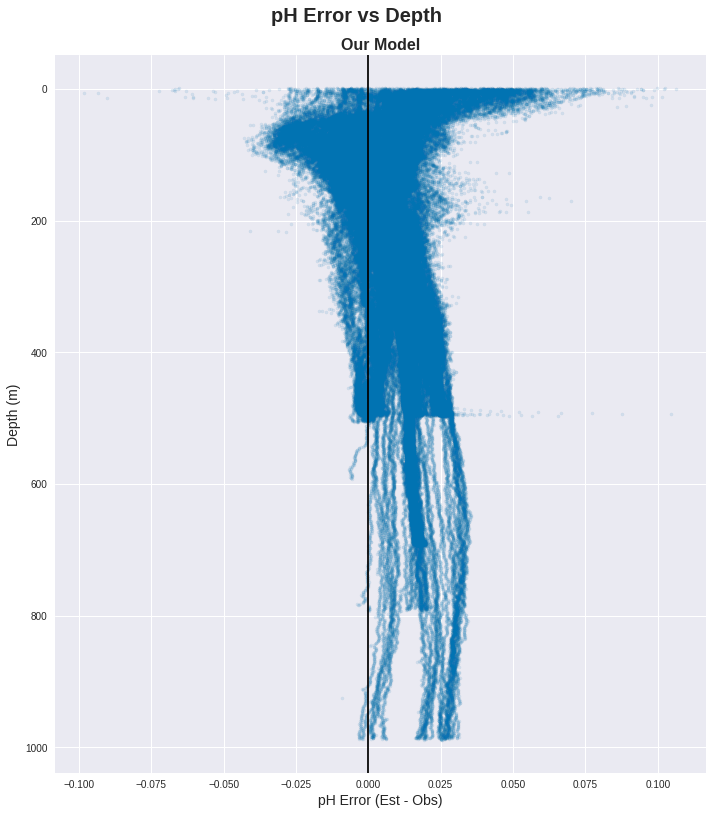

In [22]:
# get errors (estimations - observations)
error = test_predictions - test_outputs

fig, ax = plt.subplots(1, figsize=(10,11))

# plot the scatter plots
ax.scatter(error, test_depths, label=final_model_name, 
           color=m_col, s=10, alpha=0.1)

# place a vertical line at x=0 to represent error=0
ax.axvline(x=0, color='black')
# invert y-axis to better represent depth
ax.invert_yaxis()
ax.set_xlabel('pH Error (Est - Obs)')
ax.xaxis.label.set_size(14)
ax.set_ylabel('Depth (m)')
ax.yaxis.label.set_size(14)

# label plot
fig.suptitle('pH Error vs Depth', y=1.025,
             fontsize=20, weight='bold')
ax.set_title(final_model_name, fontsize=16, weight='bold')

plt.tight_layout()

# show plot
if save_figs:
  plt.savefig(fig_dir+'err_v_depth.png', bbox_inches='tight')
if show_figs:
  plt.show()


### Shallow Test Dataset

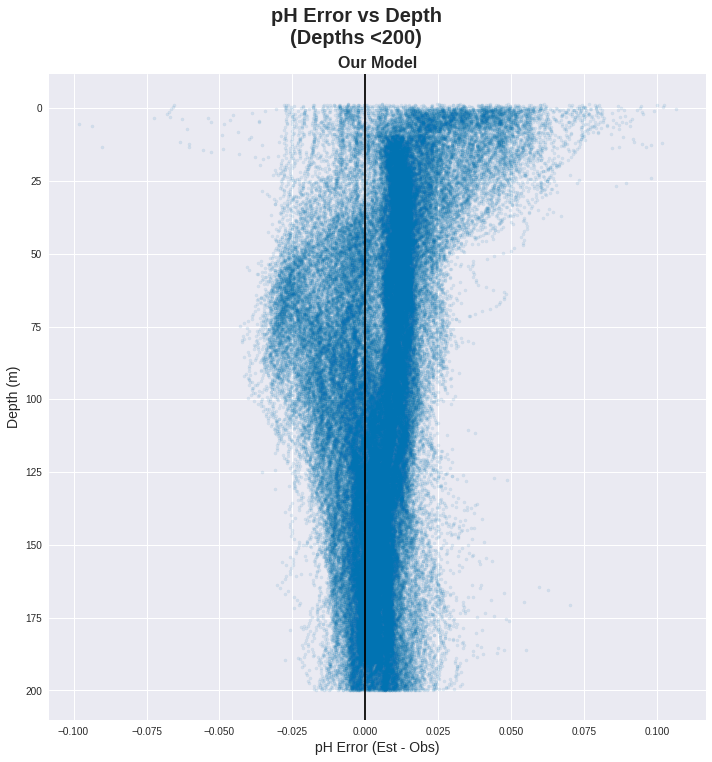

In [23]:

# get errors (estimations - observations)
shallow_error = shallow_test_predictions - shallow_outputs

fig, ax = plt.subplots(figsize=(10,10))

# plot the scatter plots
ax.scatter(shallow_error, shallow_test_depths, label=final_model_name, 
           color=m_col, s=10, alpha=0.1)

# place a vertical line at x=0 to represent error=0
ax.axvline(x=0, color='black')
# invert y-axis to better represent depth
ax.invert_yaxis()
ax.set_xlabel('pH Error (Est - Obs)')
ax.xaxis.label.set_size(14)
ax.set_ylabel('Depth (m)')
ax.yaxis.label.set_size(14)

# label plot
fig.suptitle('pH Error vs Depth' + d_label, y=1.025,
             va='center', fontsize=20, weight='bold')
ax.set_title(final_model_name, fontsize=16, weight='bold')

plt.tight_layout()

# save and show plot
if save_figs:
  plt.savefig(fig_dir+'err_v_depth_shallow.png', bbox_inches='tight')
if show_figs:
  plt.show()


## Heatmaps

In [24]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"]  = 2

### Overall Test Dataset

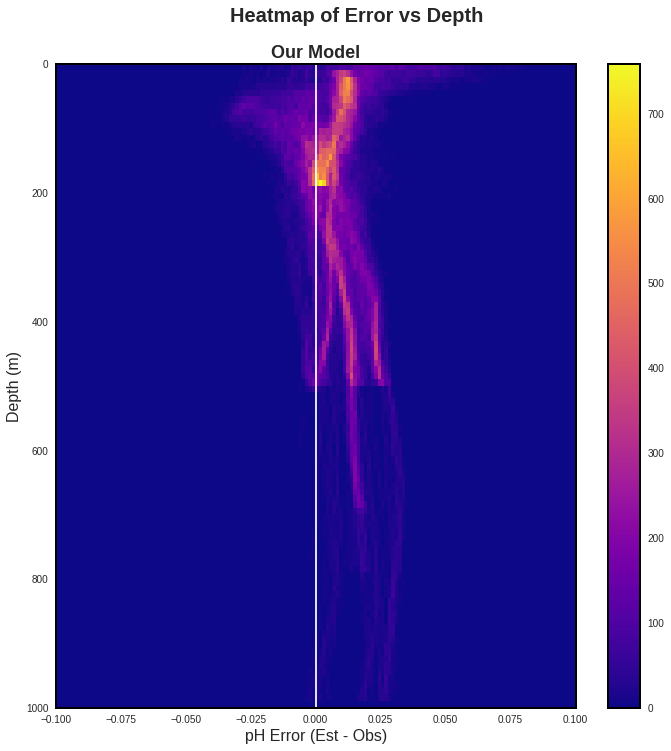

In [25]:


fig, ax1 = plt.subplots(1, figsize=(10,10))

ranges = [[-0.1, 0.1],
          [0, 1000]]

hh1 = ax1.hist2d(error, test_depths, 
                 range=ranges, bins=(150,100), cmap=plt.cm.plasma)
ax1.invert_yaxis()
ax1.axvline(x=0, color='w')
fig.colorbar(hh1[3], ax=ax1)

fig.suptitle('Heatmap of Error vs Depth', y=1.025,
             ha='center', va='center', fontsize=20, weight='bold')
ax1.set_title(final_model_name, fontsize=18, weight='bold')

ax1.set_xlabel('pH Error (Est - Obs)')
ax1.xaxis.label.set_size(16)
ax1.set_ylabel('Depth (m)')
ax1.yaxis.label.set_size(16)

plt.tight_layout()

if save_figs:
  plt.savefig(fig_dir + 'err_v_depth_heatmap.png', bbox_inches='tight')
if show_figs:
  plt.show()

### Shallow Test Dataset

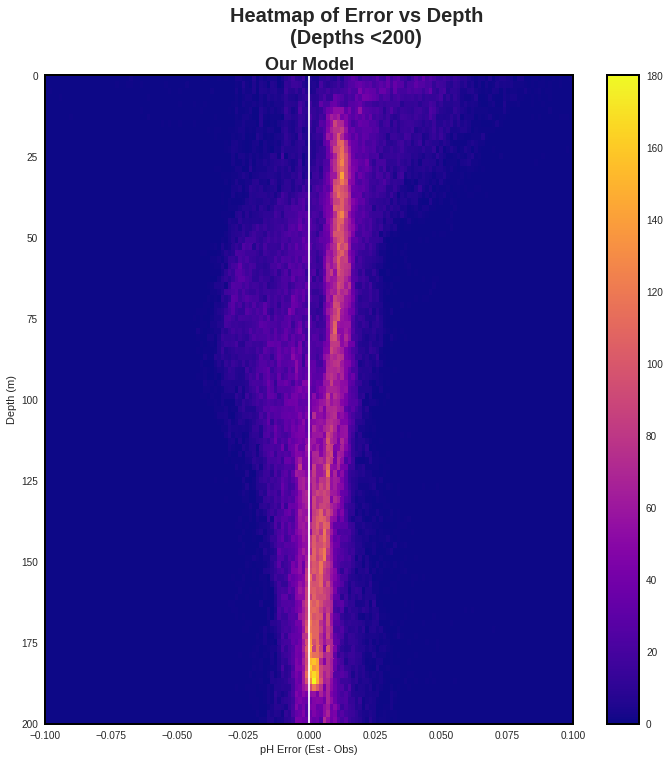

In [26]:
fig, ax1 = plt.subplots(1, figsize=(10,10))

ranges = [[-0.1, 0.1],
          [0,shallow]]

hh1 = ax1.hist2d(shallow_error, shallow_test_depths, 
                 range=ranges, bins=(150,100), cmap=plt.cm.plasma)
ax1.invert_yaxis()
ax1.axvline(x=0, color='w')
fig.colorbar(hh1[3], ax=ax1)

fig.suptitle('Heatmap of Error vs Depth' + d_label, y=1.025,
             ha='center', va='center', fontsize=20, weight='bold')
ax1.set_title(final_model_name, fontsize=18, weight='bold')

ax1.set_xlabel('pH Error (Est - Obs)')
ax1.set_ylabel('Depth (m)')

plt.tight_layout()

if save_figs:
  plt.savefig(fig_dir+'err_v_depth_heatmap_shallow.png', bbox_inches='tight')
if show_figs:
  plt.show()